# Visualise, Correlate, Predict
Author: Ian Coleman <br>
Purpose: Data Science Challenge as below

In [96]:
# ---------------------------------

# The sample data includes following columns:

# * [column 1]: sample names
# * [column 2]: disease status y [1(diseased) & 0(not diseased)]
# * [column 3-12]: 10 features X1,....,X10

# Your tasks are:
# 1) Visualize the data using e.g. R/Python.
# 2) Can you find out which of the 10 features are associated to the disease status y and why?
# 3) Build a model for disease status prediction and evaluate your model.

# ---------------------------------

### Establish Env

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import seaborn as sns

### Import Data, Overview

In [98]:
df = pd.read_csv('data.tsv', sep='\t')
print('Shape: ', df.shape)
df.sample(2)

Shape:  (100, 12)


,Name,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
13,Sample_14,1,-7.291514,4.876042,1.587380,-0.531768,1.105379,-2.031836,6.789458,0.841261,-5.229782,2.044504
57,Sample_58,0,-8.985805,4.174307,-0.470402,-2.930469,3.425190,-2.354648,4.432429,-1.417822,1.972129,2.596353


In [99]:
# 100 observations
# 10 features --> biological samples of unknown background
# Binary outcome --> does or does not have disease

In [100]:
df.describe()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.500000,-5.102348,4.074683,2.113860,-1.272770,1.941356,-2.046476,5.056326,0.148382,-1.149578,2.029137
std,0.502519,2.341112,1.085460,2.793793,2.094911,1.110827,0.533533,1.468583,1.910968,1.832206,0.530362
min,0.000000,-10.098214,1.459342,-5.944515,-6.260319,-0.123066,-3.511152,0.965622,-4.422314,-5.939233,0.230207
25%,0.000000,-6.523894,3.411222,0.095012,-2.338043,1.153160,-2.344421,4.092539,-1.043528,-2.294476,1.705572
50%,0.500000,-5.122969,4.072467,2.180125,-1.222872,1.753379,-2.120063,4.961916,0.231546,-1.155510,2.051032
75%,1.000000,-3.278668,4.842554,4.131111,-0.031634,2.782939,-1.723680,6.280935,1.298053,0.109281,2.422797
max,1.000000,1.307943,6.919229,7.740567,4.562774,4.410060,-0.658039,8.260527,4.549872,3.344339,3.172213


In [101]:
df.dtypes

Name     object
y         int64
X1      float64
X2      float64
X3      float64
X4      float64
X5      float64
X6      float64
X7      float64
X8      float64
X9      float64
X10     float64
dtype: object

In [102]:
df.isna().sum()

Name    0
y       0
X1      0
X2      0
X3      0
X4      0
X5      0
X6      0
X7      0
X8      0
X9      0
X10     0
dtype: int64

In [103]:
# Based on above, no NaN's, now check for outliers

### Visualise

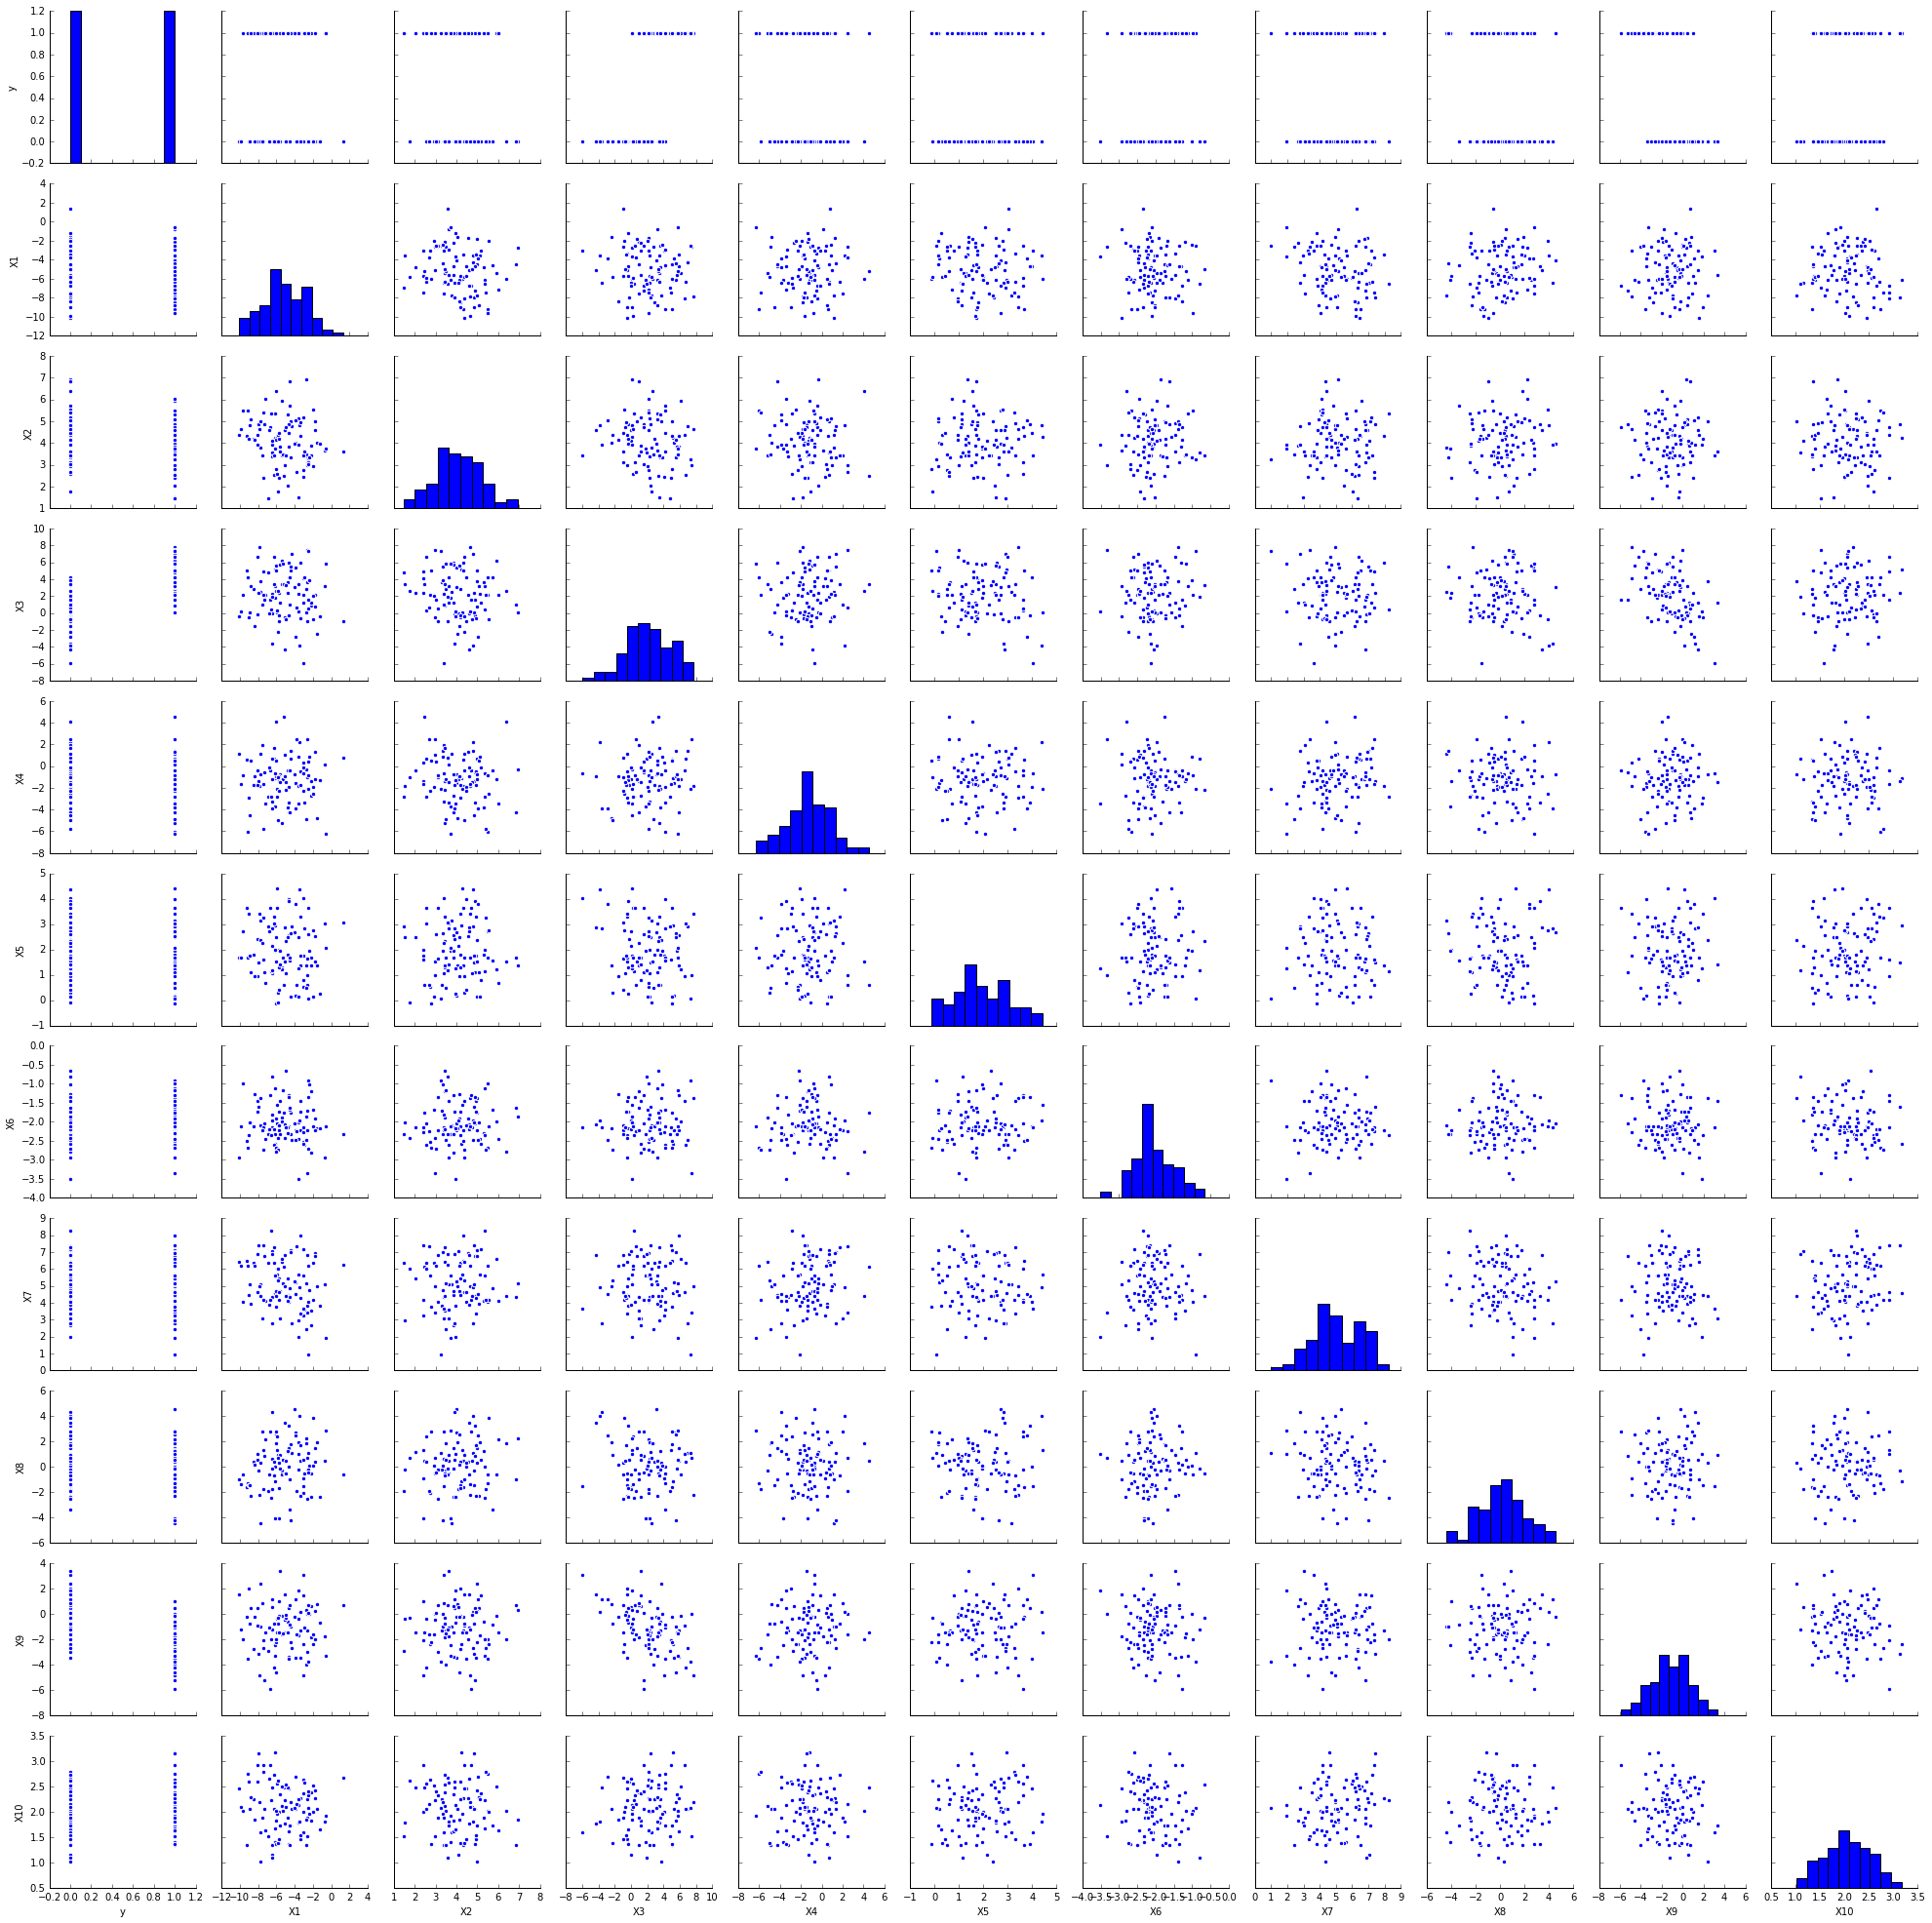

In [111]:
# Pairwise scatterplot --> visually assess for independence of features and for outliers
sns.pairplot(df)
# Conclusion --> couple of potential outliers, will be cautious trimming due to low sample size
# --> features appear to be independent, will run correlation metric to be on the safe side
# Actually x3 and x9 may have some correlation
# All appear to be within a stone's throw of normal distribution

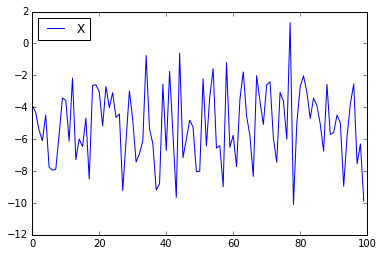

In [104]:
# Plot all features and outcome var on a line graph - all seem to be in ~ same range, diff colour for y
plt.plot(df.X1)
plt.legend('X1', ncol=2, loc='upper left');

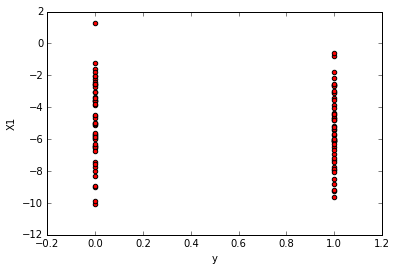

In [105]:
df.plot(kind='scatter', x='y', y='X1', color='r') 

In [106]:
# Pairwise plot correlations of x's and y

In [107]:
# Pairwise get distance correlation of x's and y 

In [108]:
# Visually assess each for outliers

### Clean

In [110]:
# Replace outliers with mean value of column - could delete row but observations are limited
# Here an outlier is any value outside of 3 std devs

# Iterate through all X and y cols, replace outliers with mean
for col in df.columns[1:]:
    df[col] = df[np.abs(df[col]-df[col].mean()) <= (3*df[col].std())][col]
    mean = df[col].mean()
    df[col] = df[col].fillna(mean)

### Create Predictive Model


In [ ]:
# Choosing model --> binary outcome classification
# Logistic Regression, Tree-based methods, 
# We have like 8.5:1 observations to features, a little underpowered. ?PCA